In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score
import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix
import warnings
warnings.filterwarnings('ignore')

# dataset

In [2]:
df = pd.read_csv('train.csv')
df['HasCrCard'] = df['HasCrCard'].astype('int')
df['IsActiveMember'] = df['IsActiveMember'].astype('int')
df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1,0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1,1,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1,0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1,1,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1,1,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1,1,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0,0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1,1,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0,1,71173.03,0


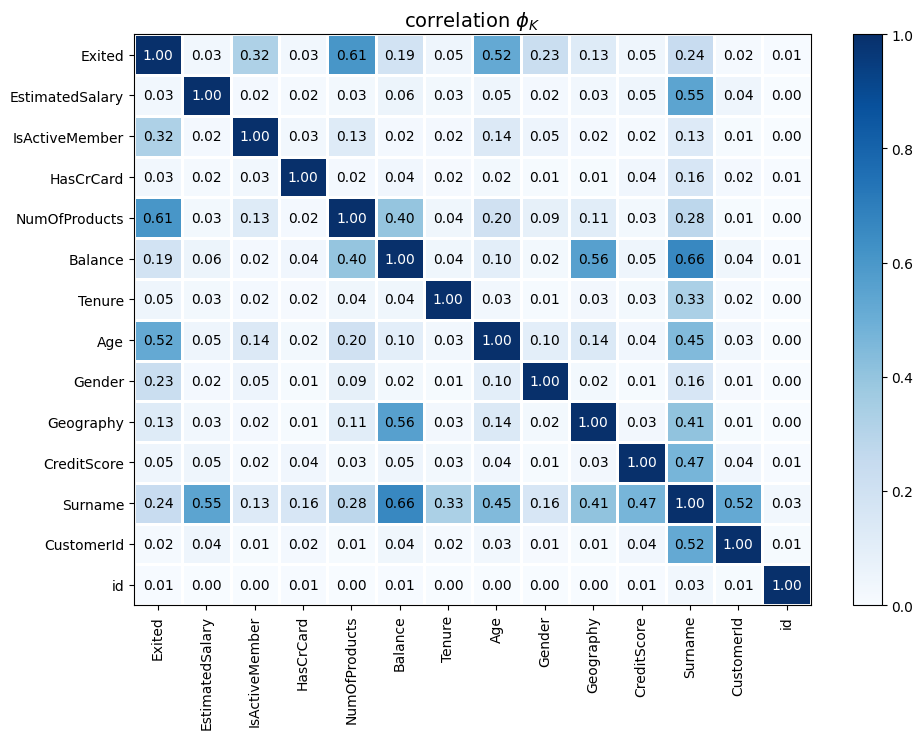

In [3]:
interval_cols = df.select_dtypes('number').columns
phik_overview = df.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', figsize=(10,7.5))
plt.tight_layout()

# WoE functions

In [4]:
def WoE(data, feature_name, target_name):
    woe_df = data.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0:'# of non-events'})
    woe_df['Percentage events'] = woe_df['# of events'] / woe_df['# of events'].sum()
    woe_df['Percentage non-events'] = woe_df['# of non-events'] / woe_df['# of non-events'].sum()
    woe_df['WoE'] = np.log(woe_df['Percentage events'] / woe_df['Percentage non-events'])
    woe_df['IV'] = (woe_df['Percentage events'] - woe_df['Percentage non-events']) * woe_df['WoE'] 
    woe_df['Total Observations'] = woe_df['# of events'] + woe_df['# of non-events']
    woe_df['Percent of Observations'] = (woe_df['Total Observations'] / woe_df['Total Observations'].sum() * 100).round(3)

    return woe_df

def plot_woe(data, x_axis_rotation, sort = False):
    if sort:
        data = data.sort_values(by='WoE', ascending=True)
    plt.grid()
    sns.pointplot(data=data, x=data.index, y='WoE', color='red', linewidth=2)
    plt.xticks(rotation=x_axis_rotation)
    plt.show()

def plot_woe2(woe, sort=False):
    if sort:
        woe = woe.sort_values(by='WoE', ascending=True)
    
    display(woe)

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    sns.pointplot(data=woe, x=woe.index, y='WoE', color='red', linewidth=2, ax=ax1)
    ax1.set_ylabel('Weight of Evidence (WoE)', color='red')
    ax1.tick_params(axis='y', colors='red')
    ax1.set_xlabel('Cats')

    sns.barplot(data=woe, x=woe.index, y='Percent of Observations', alpha=0.3, ax=ax2, errorbar=None)
    ax2.set_ylabel('Rate of Observations')
    ax2.set_ylim(0, woe['Percent of Observations'].max())
    ax2.axhline(y=5, color='red', linestyle='--', linewidth=1.5)
    ax1.grid()
    plt.show()

# encoding

## geografy

Exited,# of non-events,# of events,Percentage events,Percentage non-events,WoE,IV,Total Observations,Percent of Observations
Geography,,,,,,,,
France,78643,15572,0.445921,0.604421,-0.304129,0.048204,94215,57.088
Spain,29978,6235,0.178546,0.230400,-0.254970,0.013221,36213,21.943
Germany,21492,13114,0.375533,0.165179,0.821315,0.172767,34606,20.969


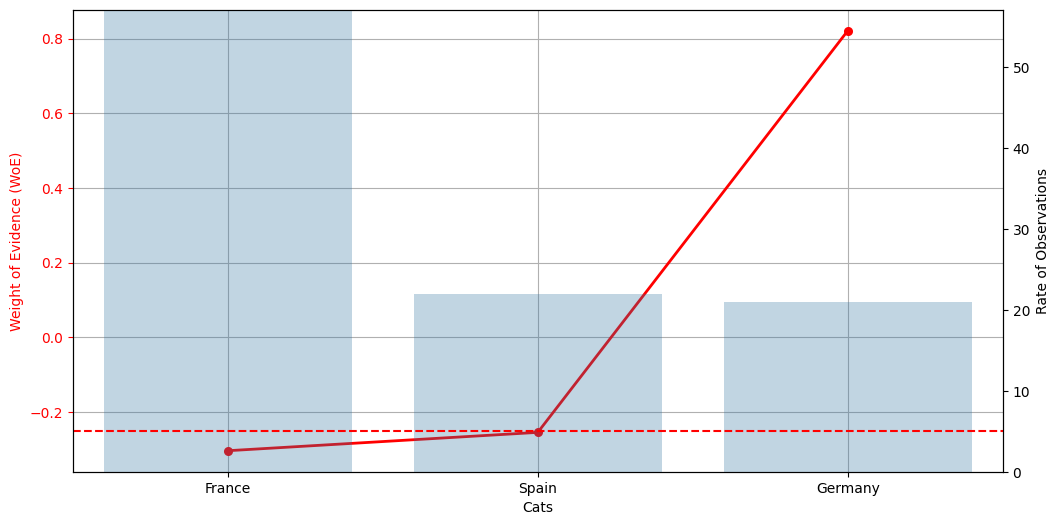

In [5]:
woe = WoE(data=df, feature_name='Geography', target_name='Exited')
plot_woe2(woe=woe, sort=True)

In [6]:
df['Country'] = df['Geography'].replace({'France':0, 'Spain':0, 'Germany':1})
df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1,0,181449.97,0,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1,1,49503.50,0,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1,0,184866.69,0,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1,1,84560.88,0,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1,1,15068.83,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1,1,131834.75,0,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0,0,131834.45,0,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1,1,127429.56,0,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0,1,71173.03,0,0


## gender

Exited,# of non-events,# of events,Percentage events,Percentage non-events,WoE,IV,Total Observations,Percent of Observations
Gender,,,,,,,,
Male,78334,14816,0.424272,0.602046,-0.349959,0.062214,93150,56.443
Female,51779,20105,0.575728,0.397954,0.369299,0.065652,71884,43.557


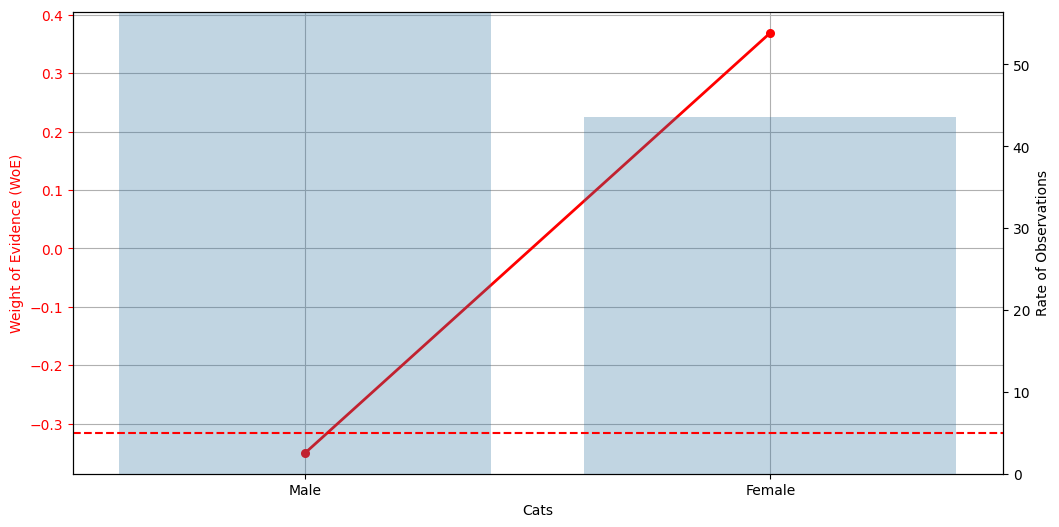

In [7]:
woe_gender = WoE(data=df, feature_name='Gender', target_name='Exited')
plot_woe2(woe=woe_gender, sort=True)

In [8]:
df['Female'] = df['Gender'].replace({'Male':0, 'Female':1})
df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country,Female
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1,0,181449.97,0,0,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1,1,49503.50,0,0,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1,0,184866.69,0,0,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1,1,84560.88,0,0,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1,1,15068.83,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1,1,131834.75,0,0,1
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0,0,131834.45,0,0,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1,1,127429.56,0,0,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0,1,71173.03,0,0,1


## numberofproducts

Exited,# of non-events,# of events,Percentage events,Percentage non-events,WoE,IV,Total Observations,Percent of Observations
NumOfProducts,,,,,,,,
1,50516,26858,0.769107,0.388247,0.683589,0.260352,77374,46.884
2,79198,5093,0.145843,0.608686,-1.428769,0.661296,84291,51.075
3,340,2554,0.073137,0.002613,3.331785,0.234969,2894,1.754
4,59,416,0.011913,0.000453,3.268463,0.037454,475,0.288


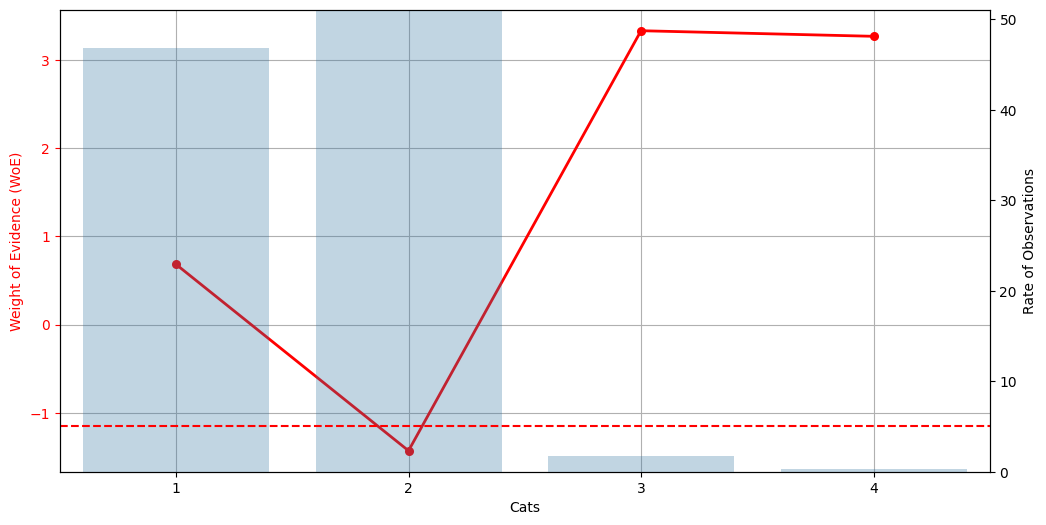

In [9]:
woe_nop = WoE(data=df, feature_name='NumOfProducts', target_name='Exited')
plot_woe2(woe=woe_nop)

In [10]:
df['NumOfProducts Binary'] = df['NumOfProducts'].replace({2:0, 1:1, 3:1, 4:1})
df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country,Female,NumOfProducts Binary
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1,0,181449.97,0,0,0,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1,1,49503.50,0,0,0,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1,0,184866.69,0,0,0,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1,1,84560.88,0,0,0,1
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1,1,15068.83,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1,1,131834.75,0,0,1,1
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0,0,131834.45,0,0,0,1
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1,1,127429.56,0,0,0,1
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0,1,71173.03,0,0,1,1


## age

Exited,# of non-events,# of events,Percentage events,Percentage non-events,WoE,IV,Total Observations,Percent of Observations
Age_cat,,,,,,,,
"(17.999, 30.0]",26483,2386,0.068326,0.203538,-1.091570,0.147594,28869,17.493
"(30.0, 33.0]",21156,2017,0.057759,0.162597,-1.034997,0.108507,23173,14.041
"(33.0, 36.0]",23603,2696,0.077203,0.181404,-0.854290,0.089018,26299,15.936
"(36.0, 38.0]",16201,2301,0.065892,0.124515,-0.636414,0.037309,18502,11.211
"(38.0, 41.0]",17904,4443,0.127230,0.137603,-0.078379,0.000813,22347,13.541
"(41.0, 47.0]",14923,9335,0.267318,0.114693,0.846182,0.129149,24258,14.699
"(47.0, 92.0]",9843,11743,0.336273,0.075650,1.491812,0.388801,21586,13.080


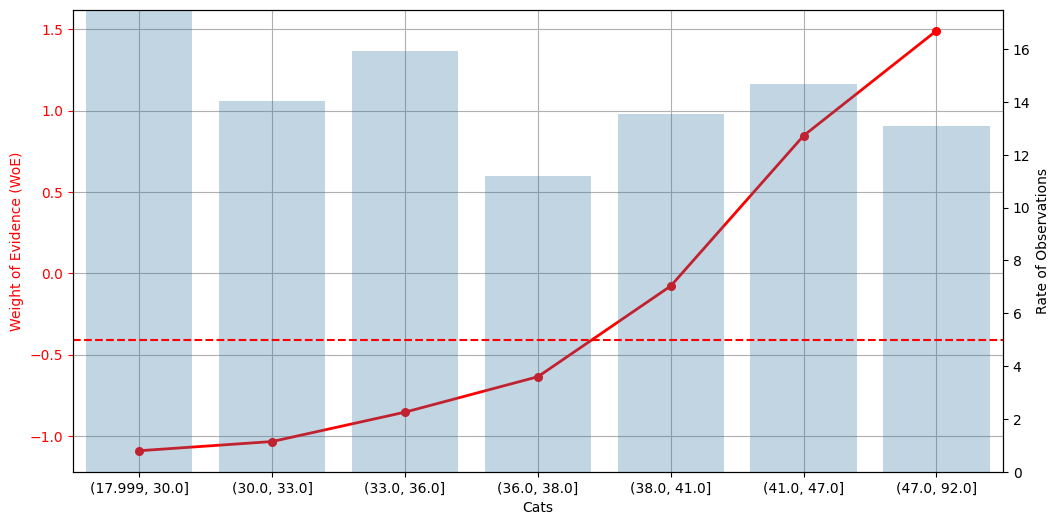

In [11]:
df['Age_cat'] = pd.qcut(df['Age'], q=7)
woe_age = WoE(data=df, feature_name='Age_cat', target_name='Exited')
plot_woe2(woe=woe_age)

In [12]:
df['Age_cat_rank'] = df['Age_cat'].rank(method='dense').astype('int')
df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country,Female,NumOfProducts Binary,Age_cat,Age_cat_rank
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1,0,181449.97,0,0,0,0,"(30.0, 33.0]",2
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1,1,49503.50,0,0,0,0,"(30.0, 33.0]",2
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1,0,184866.69,0,0,0,0,"(38.0, 41.0]",5
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1,1,84560.88,0,0,0,1,"(33.0, 36.0]",3
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1,1,15068.83,0,0,0,0,"(30.0, 33.0]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1,1,131834.75,0,0,1,1,"(30.0, 33.0]",2
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0,0,131834.45,0,0,0,1,"(33.0, 36.0]",3
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1,1,127429.56,0,0,0,1,"(30.0, 33.0]",2
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0,1,71173.03,0,0,1,1,"(17.999, 30.0]",1


## balance

Exited,# of non-events,# of events,Percentage events,Percentage non-events,WoE,IV,Total Observations,Percent of Observations
Balance_cat,,,,,,,,
"(-1, 0]",75156,14492,0.414994,0.577621,-0.330654,0.053773,89648,54.321
"(0, 1200000]",54957,20429,0.585006,0.422379,0.325719,0.052971,75386,45.679


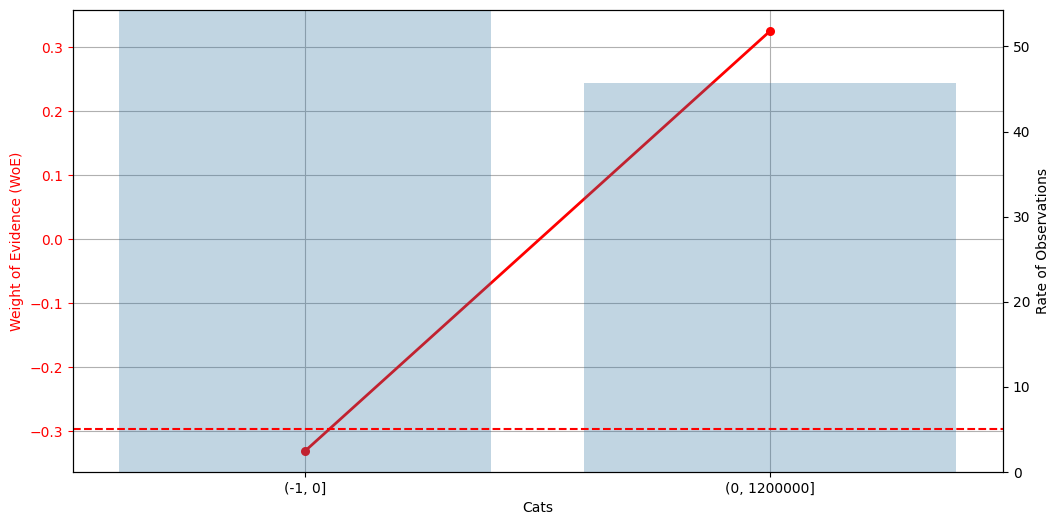

In [13]:
df['Balance_cat'] = pd.cut(df['Balance'], bins=[-1, 0, 1200000])
woe_balance = WoE(data=df, feature_name='Balance_cat', target_name='Exited')
plot_woe2(woe=woe_balance)

In [14]:
df['HasBalance'] = df['Balance'].agg(lambda x: 0 if x==0 else 1)
df = df.drop(columns=['Balance_cat'])
df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country,Female,NumOfProducts Binary,Age_cat,Age_cat_rank,HasBalance
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1,0,181449.97,0,0,0,0,"(30.0, 33.0]",2,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1,1,49503.50,0,0,0,0,"(30.0, 33.0]",2,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1,0,184866.69,0,0,0,0,"(38.0, 41.0]",5,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1,1,84560.88,0,0,0,1,"(33.0, 36.0]",3,1
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1,1,15068.83,0,0,0,0,"(30.0, 33.0]",2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1,1,131834.75,0,0,1,1,"(30.0, 33.0]",2,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0,0,131834.45,0,0,0,1,"(33.0, 36.0]",3,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1,1,127429.56,0,0,0,1,"(30.0, 33.0]",2,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0,1,71173.03,0,0,1,1,"(17.999, 30.0]",1,1


# correlations

In [15]:
from scipy.stats import kendalltau, spearmanr, pearsonr, pointbiserialr
from scipy.stats import chi2_contingency
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

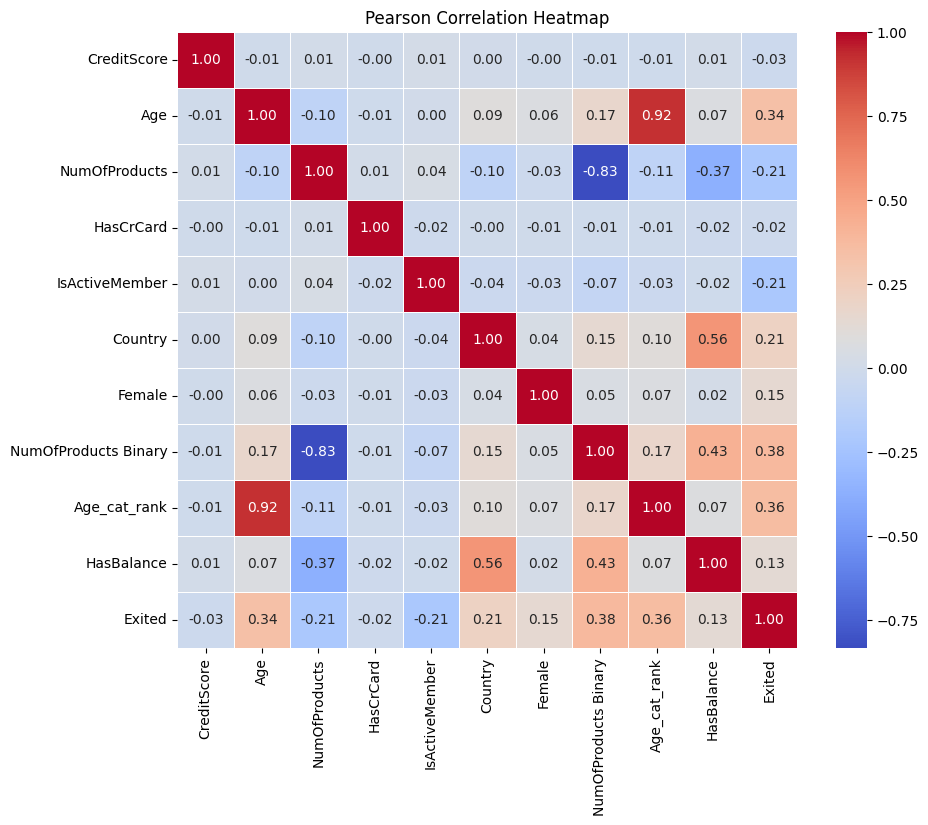

In [16]:
correlation_matrix = df[['CreditScore', 'Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
                         'Country', 'Female', 'NumOfProducts Binary', 
                         'Age_cat_rank', 'HasBalance', 'Exited']].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Pearson Correlation Heatmap')
plt.show()

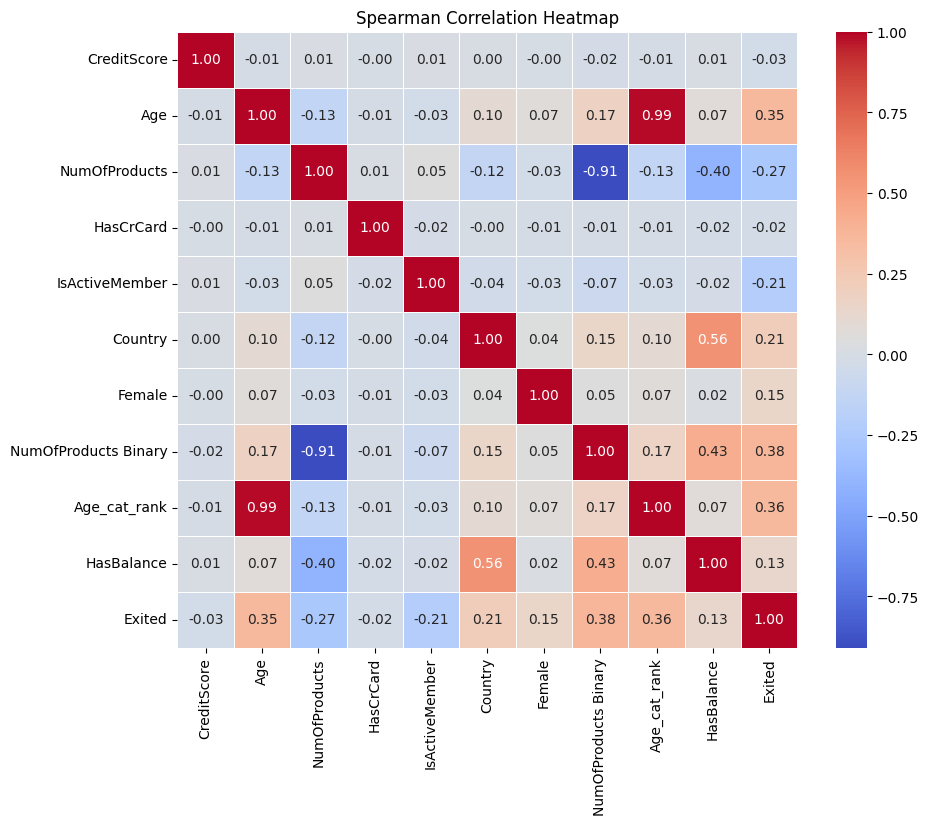

In [17]:
correlation_matrix = df[['CreditScore', 'Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
                         'Country', 'Female', 'NumOfProducts Binary', 
                         'Age_cat_rank', 'HasBalance', 'Exited']].corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Spearman Correlation Heatmap')
plt.show()

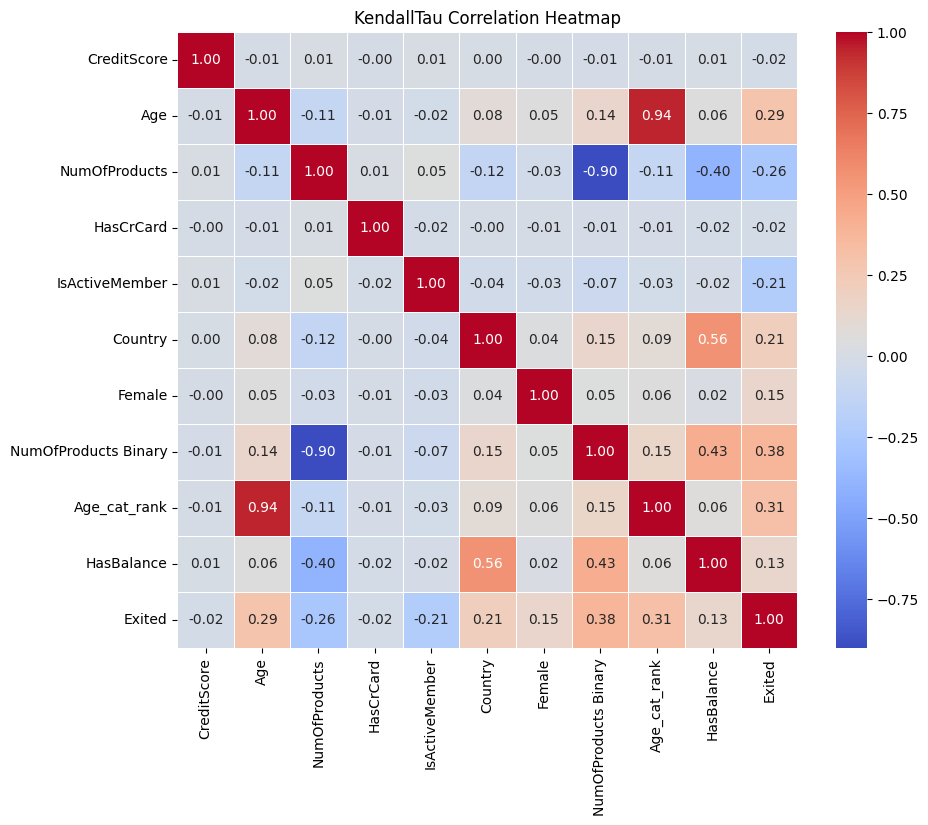

In [18]:
correlation_matrix = df[['CreditScore', 'Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
                         'Country', 'Female', 'NumOfProducts Binary', 
                         'Age_cat_rank', 'HasBalance', 'Exited']].corr(method='kendall')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('KendallTau Correlation Heatmap')
plt.show()

In [19]:
print(f"""PointBiserial
Feature       coef
Female:   {pointbiserialr(df['Female'], df['Exited'])[0]}
NumOfP:   {pointbiserialr(df['NumOfProducts Binary'], df['Exited'])[0]}
Country:  {pointbiserialr(df['Country'], df['Exited'])[0]}
IsActive: {pointbiserialr(df['IsActiveMember'], df['Exited'])[0]}
HasCard:  {pointbiserialr(df['HasCrCard'], df['Exited'])[0]}
""")

PointBiserial
Feature       coef
Female:   0.14644155895393066
NumOfP:   0.37817617823330985
Country:  0.21105372649562498
IsActive: -0.21023702579213768
HasCard:  -0.022141333072306698



In [20]:
print(f"""
Kendall Tau
Feature_name   coef
Age_cat:       {kendalltau(df['Age_cat_rank'], df['Exited'])[0]}
NumOfProducts: {kendalltau(df['NumOfProducts'], df['Exited'])[0]}
Tenure:        {kendalltau(df['Tenure'], df['Exited'])[0]}
""")


Kendall Tau
Feature_name   coef
Age_cat:       0.31044547122541094
NumOfProducts: -0.2642205811931589
Tenure:        -0.016565555562445506



In [21]:
print(f"""


""")

# model

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import StackingClassifier

interval columns not set, guessing: ['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Country', 'Female', 'NumOfProducts Binary', 'Age_cat_rank', 'HasBalance']


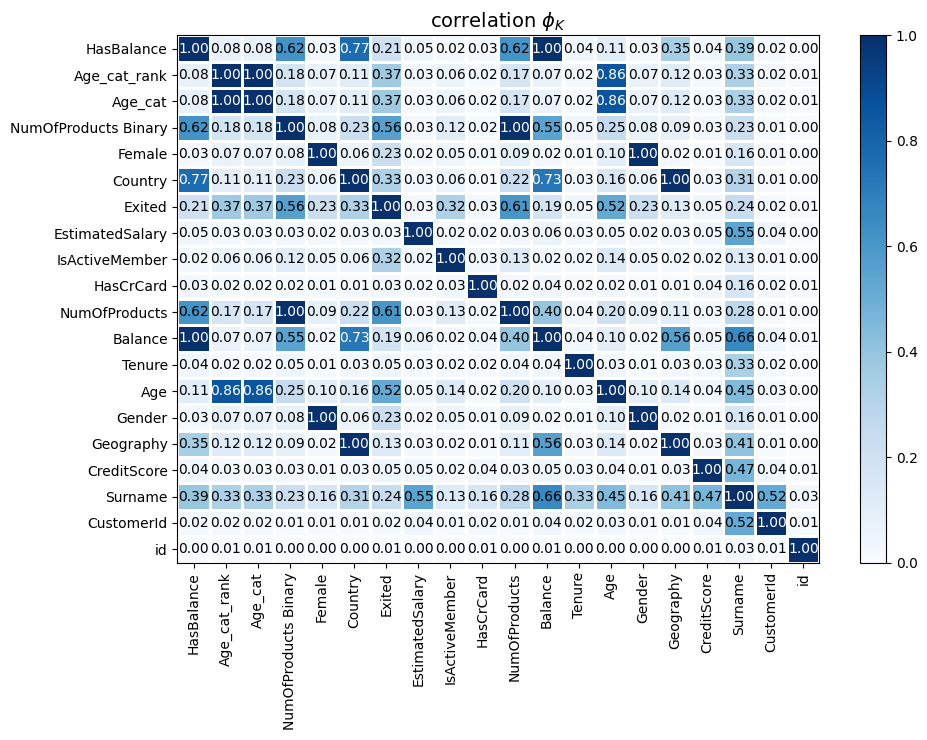

In [23]:
phik_overview = df.phik_matrix()
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', figsize=(10,7.5))
plt.tight_layout()

In [24]:
X = df.drop(columns=['CustomerId', 'Surname', 'Geography', 'Gender', 'Exited', 'Age_cat', 'EstimatedSalary', 'Balance', 'Tenure', 'id'])
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
estimators = [
    ('lr_l1', LogisticRegression(penalty='l1', solver='liblinear', C=0.5)),
    ('lr_l2', LogisticRegression(penalty='l2', C=1.0)),
    ('ridge', RidgeClassifier())
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(penalty='l2', C=1.0),
    cv=5 
)

stacking_clf.fit(X_train, y_train)
stacking_pred = stacking_clf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, stacking_pred)

0.8729379049029948

Best threshold: 0.18348752511609925

Confusion matrix: 
[[31146  7987]
 [ 2082  8296]]


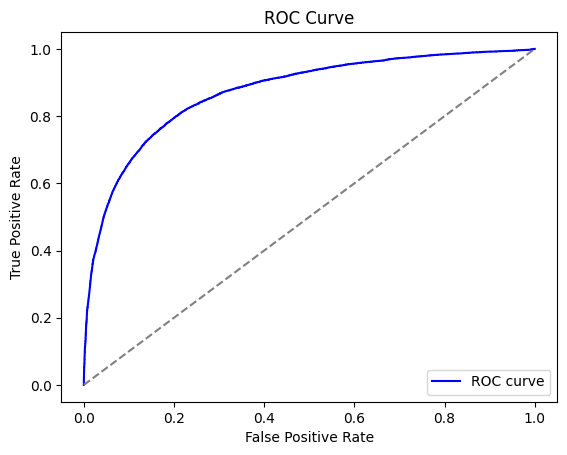

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, stacking_pred)

best_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_index]
print(f"Best threshold: {best_threshold}\n")
print(f"Confusion matrix: \n{confusion_matrix(y_test, (stacking_pred >= best_threshold).astype(int))}")

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# prediction

In [27]:
# test data

test = pd.read_csv('test.csv')
test['HasCrCard'] = test['HasCrCard'].astype('int')
test['IsActiveMember'] = test['IsActiveMember'].astype('int')
test['Country'] = test['Geography'].replace({'France':0, 'Spain':0, 'Germany':1})
test['Female'] = test['Gender'].replace({'Male':0, 'Female':1})
test['NumOfProducts Binary'] = test['NumOfProducts'].replace({2:0, 1:1, 3:1, 4:1})
test['Age_cat'] = pd.qcut(test['Age'], q=7)
test['Age_cat_rank'] = test['Age_cat'].rank(method='dense').astype('int')
test['HasBalance'] = test['Balance'].agg(lambda x: 0 if x==0 else 1)
test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Country,Female,NumOfProducts Binary,Age_cat,Age_cat_rank,HasBalance
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0,1,160976.75,0,1,0,"(17.999, 30.0]",1,0
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1,0,72549.27,0,1,1,"(41.0, 47.0]",6,0
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1,0,138882.09,0,1,0,"(33.0, 36.0]",3,0
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1,0,113931.57,0,0,1,"(33.0, 36.0]",3,0
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1,0,139431.00,1,0,1,"(36.0, 38.0]",4,1


In [28]:
X_train1 = df.drop(columns=['id', 'CustomerId', 'Surname', 'Geography', 'Gender', 'Age_cat', 'EstimatedSalary', 'Balance', 'Tenure', 'Exited', 'HasCrCard', 'CreditScore'])
y_train1 = df['Exited']
X_test1 = test.drop(columns=['id', 'CustomerId', 'Surname', 'Geography', 'Gender', 'Age_cat', 'EstimatedSalary', 'Balance', 'Tenure', 'HasCrCard', 'CreditScore'])

In [29]:
estimators = [
    ('lr_l1', LogisticRegression(penalty='l1', solver='liblinear', C=0.5)),
    ('lr_l2', LogisticRegression(penalty='l2', C=1.0)),
    ('ridge', RidgeClassifier())
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(penalty='l2', C=1.0),
    cv=5
)
stacking_clf.fit(X_train1, y_train1)
stacking_pred = stacking_clf.predict_proba(X_test1)[:, 1]

In [30]:
result = pd.DataFrame({'id':test['id'], 'Exited':stacking_pred})
result

,id,Exited
0,165034,0.021384
1,165035,0.756375
2,165036,0.073789
3,165037,0.243268
4,165038,0.513039
...,...,...
110018,275052,0.032911
110019,275053,0.084917
110020,275054,0.038121
110021,275055,0.117288


In [31]:
# result.to_csv('MySubmission.csv', index=False)